### minimal version of DS agent
- setting: one shot answer
- architecture:
    - load_data: preload data
    - eda_agent:
        - generate_eda_code: call LLM to generate code, maximal one plot
        - execute_code: handles code execution and IO
        - reflect_and_improve: call LLM to improve code, multimodal
        - present_result: call LLM to summarize and present results
- flow:
    - user query 
    - generate code
    - execute code
    - critique and generate improved code
    - execute code
    - present results

- evaluation:
    - 10 question and answer pairs on the eleme dataset
    - use LLM as a judge

In [ ]:
# Standard library
import re
import io
import sys
import traceback
import json
from pathlib import Path

# Third-party
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from IPython.display import display, Image, HTML
from openai import OpenAI
from dotenv import load_dotenv

# load common utilities
%load_ext autoreload
%autoreload 2
from util import *


# Load environment variables
load_dotenv()

# Initialize OpenAI client
client = OpenAI()


# Configure matplotlib for Chinese text rendering
import platform

# Detect OS and set appropriate Chinese fonts
os_name = platform.system()

if os_name == "Darwin":  # macOS
    chinese_fonts = ['PingFang SC', 'STHeiti', 'Arial Unicode MS']
elif os_name == "Windows":
    chinese_fonts = ['Microsoft YaHei', 'SimHei', 'KaiTi']
else:  # Linux
    chinese_fonts = ['WenQuanYi Micro Hei', 'Noto Sans CJK SC', 'Droid Sans Fallback']

# Set font family with Chinese fonts first, then fallback to sans-serif
plt.rcParams['font.sans-serif'] = chinese_fonts + plt.rcParams['font.sans-serif']

# Fix minus sign display issue (common with Chinese fonts)
plt.rcParams['axes.unicode_minus'] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
## check data
df = load_data("../data/eleme.xlsx")
df.head()

In [2]:
def get_response(
    system_prompt,
    user_prompt,
    model="gpt-5-mini", #"gpt-5-mini",
    reasoning_effort="minimal",
    verbosity="low",
    image_path=None
):
    """
    Get response from OpenAI GPT-5 series models.
    
    Args:
        system_prompt: System instructions
        user_prompt: User query
        model: GPT-5 model to use
        reasoning_effort: "minimal", "low", "medium", "high"
        verbosity: 'low', 'medium', or 'high'
        image_path: optional image path
    Returns:
        Model response content
    """
    input_list=[]
    
    if image_path:
        import base64
        with open(image_path, "rb") as f:
            image_data=base64.b64encode(f.read()).decode()
        
        # For multimodal: we include a combined content list
        input_content=[
            {"type": "input_text", "text": user_prompt},
            {"type": "input_image", "image_url": f"data:image/png;base64,{image_data}"}
        ]
        input_list.append({"role": "user", "content": input_content})
    else:
        input_list.append({"role": "user", "content": user_prompt})

    response=client.responses.create(
        model=model,
        instructions=system_prompt,
        input=input_list,
        reasoning={"effort": reasoning_effort}, # type: ignore
        text={"verbosity": verbosity} # type: ignore
    )
    
    return response.output_text

In [3]:
# rules for coding behaviors

EDA_CODE_RULE = """
- ONLY use one or more packages in the allowed_package_list; DO NOT use or import packages that not on the list.
   - allowed_package_list: pandas, matplotlib.
- Assume the DataFrame is already loaded as 'df' and it's not empty, no need to check.
- Write clear, step-by-step code with necessary comments. Do not add explanations.
- Code should be efficient and optimized.
- Handle edge cases (empty results, missing values, etc.).
- Store final answer/insight in a variable called 'result' (string or dict).
- DO NOT print any results.
- For visualizations:
   - Create at most ONE clear, labeled plot.
   - Use plt.title(), plt.xlabel(), plt.ylabel().
   - Don't call plt.show(), plt.savefig() or plt.close().c
   - Avoid overlapping/unclear axis labels.
"""

# Define safe globals (read-only access to libraries)
SAFE_GLOBALS = {
   "pd": pd,
   "plt": plt,
   # "re": re,
   # "np": np,
   # "display": display,
   # "Image": Image,
   # "HTML": HTML,
}
    

In [66]:
def generate_eda_code(query, df, model="gpt-5-mini", include_viz=True):
    """
    Generate Python code for EDA task, with one viz maximal, using pd, plt only.
    
    Args:
        query: User's analysis request
        df: DataFrame to analyze (used for schema info)
        include_viz: Whether to include visualization in the code
        
    Returns:
        Generated Python code wrapped in <execute_python> tags
    """
    # Build schema information
    schema_text = get_schema(df)
    
    # Build prompt
    system_prompt = f"""You are a senior data analyst. Write clean python code for exploratory data analysis.
Keep it concise, focus on the specific request.
Return your answer *strictly* in this format:
<execute_python>
# valid python code here
</execute_python>

Requirements for the code:
{EDA_CODE_RULE}
"""
    
    viz_instruction = " Include ONE appropriate plot." if include_viz else ""
    
    user_prompt = f"""Dataset Schema:
{schema_text}

User Request:
{query}{viz_instruction}

Generate Python code to analyze this request."""
    
    # Call LLM
    response = get_response(
        system_prompt=system_prompt,
        user_prompt=user_prompt,
        model=model
    )
    
    return response


In [5]:
def execute_code(code, df, output_image_path=None):
    """
    Execute generated Python code in a controlled namespace.
    
    Args:
        code: Python code to execute (with or without <execute_python> tags)
        df: DataFrame to analyze
        output_image_path: Path to save matplotlib figures (optional)
        
    Returns:
        Dictionary containing:
            - code: Extracted Python code
            - stdout: Captured print statements
            - error: Error traceback (None if successful)
            - result: Value of 'result' variable if set by code
            - image_path: Path to saved image (if any)
    """
    # Extract code from tags if present
    match = re.search(r"<execute_python>(.*?)</execute_python>", code, re.DOTALL | re.IGNORECASE)
    code = match.group(1).strip() if match else code.strip()
    
    # Define safe locals (includes the DataFrame)
    namespace = {**SAFE_GLOBALS, "df": df.copy()}
    
    # Capture stdout
    stdout_buffer = io.StringIO()
    old_stdout = sys.stdout
    sys.stdout = stdout_buffer
    
    error = None
    try:
        exec(code, namespace)
        
        # Save any matplotlib figures
        if output_image_path and plt.get_fignums():
            plt.savefig(output_image_path, bbox_inches='tight', dpi=150)
            plt.close('all')  # Clean up
            
    except Exception:
        error = traceback.format_exc()
    finally:
        sys.stdout = old_stdout
    
    return {
        "code": code,
        "stdout": stdout_buffer.getvalue().strip(),
        "error": error,
        "result": namespace.get("result"),
        "image_path": output_image_path if output_image_path and Path(output_image_path).exists() else None,
    }

In [67]:
def reflect_and_improve(
    query,
    v1_code,
    v1_result,
    model="gpt-5-mini"
):
    """
    Reflect on V1 results and generate improved code.
    
    Args:
        query: Original user request
        v1_code: Code from V1
        v1_result: Execution results from V1
        
    Returns:
        feedback and improved Python code wrapped in <execute_python> tags
    """
    # Build feedback string
    feedback_parts = []
    image_path = None
    if v1_result["error"]:
        feedback_parts.append(f"ERROR:\n{v1_result['error']}")
    
    if v1_result["stdout"]:
        feedback_parts.append(f"Output:\n{v1_result['stdout']}")
    
    if v1_result["result"]:
        feedback_parts.append(f"Result variable:\n{v1_result['result']}")
    
    if v1_result["image_path"]:
        feedback_parts.append(f"Visualization provided")
        image_path = v1_result["image_path"]

    feedback = "\n\n".join(feedback_parts)
    
    # Build reflection prompt
    system_prompt = f"""You are a senior code reviewer. 

Your task:
- First, critique how well the V1 code and results answer the original request; identify issues (errors, poor analysis choices, unclear visualizations).
- Then generate V2 code that fixes these issues; keep the same output format and variable names.

STRICT OUTPUT FORMAT (JSON only):
{{
 "feedback": "<brief, specific critique and suggestions>",
 "v2_code": "<ONLY python code, wrapped in <execute_python> tags>"
}}

Requirements for the code:
{EDA_CODE_RULE}
"""
    
    user_prompt = f"""Original Request:
{query}

V1 Code:
{v1_code}

V1 Execution Results:
{feedback}

Generate feedback and improved V2 code that addresses any issues and provides better analysis/visualization."""
    
    # print(system_prompt)
    # print(user_prompt)
    # print(image_path)
    
    response = get_response(
        system_prompt=system_prompt,
        user_prompt=user_prompt,
        model=model,
        image_path=image_path
    )
    
    # Robust JSON parse
    try:
        obj = json.loads(response)
    except Exception:
        m = re.search(r"\{.*\}", response, flags=re.DOTALL)
        obj = json.loads(m.group(0)) if m else {"feedback": response, "v2_code": ""}

    feedback = str(obj.get("feedback", "")).strip()
    v2_code = str(obj.get("v2_code", "")).strip()

    return feedback, v2_code




In [68]:
def present_result(final_result, query, model="gpt-5-mini"):
    """
    Present the final_result using LLM to generate a natural language summary.
    
    Args:
        final_result: Dictionary containing execution results (from eda_agent)
        query: Original user query
        
    Returns:
        Natural language presentation of the results
    """
    # Prepare the result data for the LLM
    result_data_parts = []
    
    # Include the result variable if present
    if final_result.get("result"):
        result_data_parts.append(str(final_result['result']))

    
    result_data = "\n\n".join(result_data_parts)
    
    # Build prompt for presentation
    system_prompt = """You are a data analyst presenting EDA findings to answer the specific user question.
Your task is to:
1. Summarize the analysis in clear natural language.
2. Highlight key insights and interesting findings.
3. Explain any visualizations that were created.
4. DO NOT assume any information about the user.
5. Detect the language used in the User Question and present the answer using the SAME LANGUAGE, despite the language appeared in the Analysis Results.
"""

    viz_instruction = "Visualizations provided." if final_result.get("image_path") else ""

    user_prompt = f"""User Question:
{query}

Analysis Results:
{result_data}
{viz_instruction}

Please provide a clear, natural language summary of these findings."""
    
    # Get LLM presentation
    presentation = get_response(
        system_prompt=system_prompt,
        user_prompt=user_prompt,
        model=model,
        image_path=final_result.get("image_path")
    )
    
    return presentation

    # print(system_prompt)
    # print(user_prompt)


In [69]:
def eda_agent(
    query,
    df,
    model="gpt-5-mini",
    use_reflection=True,
    include_viz=True,
    output_dir="./output"
):
    """
    Main EDA agent that orchestrates the full workflow.
    
    Args:
        query: User's analysis request
        df: DataFrame to analyze
        use_reflection: Whether to use reflection pattern (V1 → V2)
        include_viz: Whether to include visualizations
        output_dir: Directory to save output images
        
    Returns:
        Dictionary containing:
            - query: Original request
            - v1: V1 execution results
            - v2: V2 execution results (if reflection enabled)
            - final_result: Best result (V2 if available, else V1)
    """
    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    print(f"📊 EDA Agent Processing: {query}\n")
    
    # ===== V1: Initial code generation and execution =====
    print("🔄 Generating V1 code...")
    v1_code = generate_eda_code(
        query=query,
        df=df,
        include_viz=include_viz,
        model=model
    )
    
    # print('v1_code:')
    # print(v1_code)
    print("⚙️  Executing V1 code...")
    
    v1_image_path = str(output_path / "v1_plot.png") if include_viz else None
    v1_result = execute_code(v1_code, df, v1_image_path)
    
    if v1_result["error"]:
        print(f"❌ V1 Error:\n{v1_result['error']}")
    else:
        print("✅ V1 execution successful")
    
    # ===== V2: Reflection and improved code =====
    v2_result = None
    feedback = None
    v2_code = None
    
    if use_reflection:
        print("\n🤔 Reflecting on V1 results...")
        feedback, v2_code = reflect_and_improve(
            query=query,
            v1_code=v1_result["code"],
            v1_result=v1_result,
            model=model
        )
        # print('feedback:')
        # print(feedback)
        # print('v2_code:')
        # print(v2_code)
        print("⚙️  Executing V2 code...")
        v2_image_path = str(output_path / "v2_plot.png") if include_viz else None
        v2_result = execute_code(v2_code, df, v2_image_path)
        
        if v2_result["error"]:
            print(f"❌ V2 Error:\n{v2_result['error']}")
            print("⚠️  Using V1 results as fallback")
        else:
            print("✅ V2 execution successful")
    
    # ===== Select best result =====
    final_result = v2_result if (v2_result and not v2_result["error"]) else v1_result
    
    print("Preparing final report")

    # ===== present result =====
    print("\n" + "="*60)
    print("📊 FINAL RESULT")
    print("="*60)
    
    result_summary = present_result(final_result, query, model=model)
    print_wrapped(result_summary)
    if final_result.get("image_path"):
        print(f"\n📈 Visualization: {final_result['image_path']}")
        display(Image(filename=final_result["image_path"]))
    
    

    return {
        "query": query,
        "v1_code": v1_code,
        "v1_result": v1_result,
        "feedback": feedback,
        "v2_code": v2_code,
        "v2_result": v2_result,
        "final_result": final_result,
        "result_summary": result_summary
    }

### test

In [9]:
df_eleme = load_data("../data/eleme.xlsx")

✓ Loaded data: 707 rows × 10 columns


/Users/tylerxie/airepo/edaagent/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


📊 EDA Agent Processing: tell me about the data.

🔄 Generating V1 code...
⚙️  Executing V1 code...
✅ V1 execution successful

🤔 Reflecting on V1 results...
⚙️  Executing V2 code...
✅ V2 execution successful
Preparing final report

📊 FINAL RESULT
Language detected: English.

Summary of the dataset
- Size & structure: 707 rows × 10 columns. Key columns include order time (下单时间), order ID (订单号), merchant (商户信息), items (商品及数量), item description (商品描述), recipient (收货人), address (地址), order amount (订单金额(元)), order status (订单状态), and order subtype (订单子类型).
- Data types: several fields are text (object); order ID is integer. Many fields contain missing values.

Missing data
- 商品描述 (item description) and 订单子类型 (order subtype) are almost entirely empty (705 missing of 707).
- 收货人 (recipient) has 18 missing, 地址 (address) has 33 missing.
- No missing values in 下单时间, 订单号, 商户信息, 商品及数量, 订单金额(元), and 订单状态.

Order amount (订单金额)
- 707 non-missing amounts. Mean ≈ 38.45, median = 30.00, standard deviation 

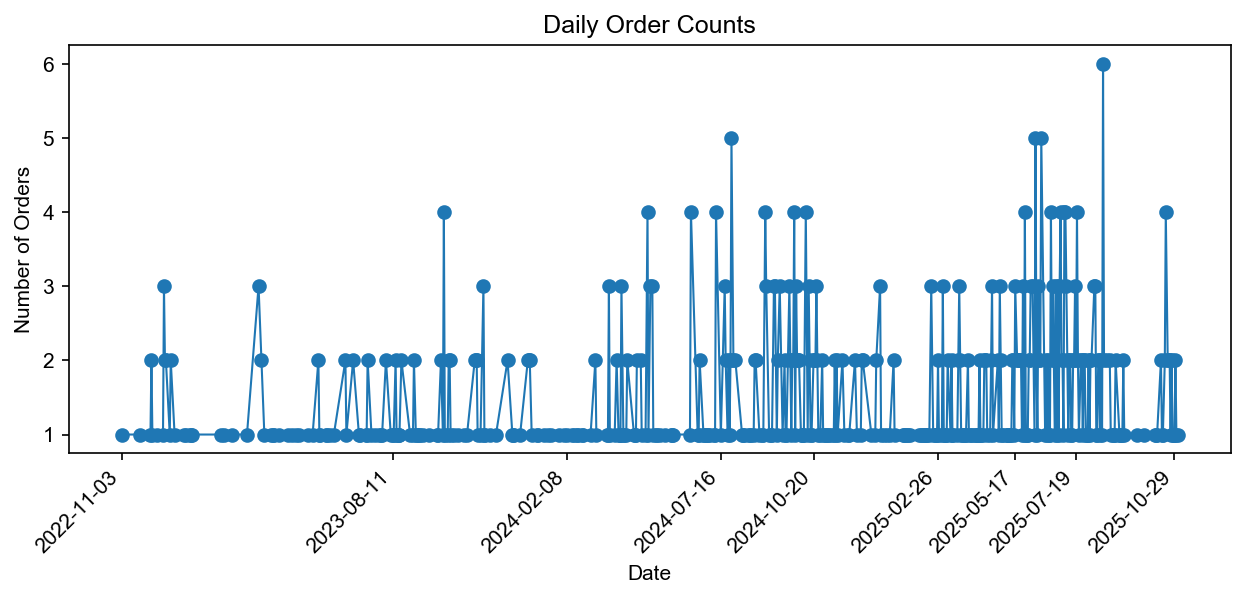

In [83]:
result1 = eda_agent(
    query="tell me about the data.",
    df=df_eleme,
    use_reflection=True,
    include_viz=True
)

📊 EDA Agent Processing: tell me about the data and find something interesting

🔄 Generating V1 code...
⚙️  Executing V1 code...
✅ V1 execution successful

🤔 Reflecting on V1 results...
⚙️  Executing V2 code...
✅ V2 execution successful
Preparing final report

📊 FINAL RESULT
Summary of the data
- Dataset contains 707 orders from 236 unique merchants.
- Average order value: $38.45 (median $30.00). Orders typically contain ~1.97 items; the largest order had 13 items.
- Small amounts of missing data: ~2.55% of recipient fields and ~4.67% of address fields are missing.

Key insights and interesting findings
- Peak order volume occurs at 19:00 (7 PM) with 83 orders. Other high-volume hours: 20:00 (76), 12:00–13:00 (53–57), and 21:00–23:00 (41–42–35).
- The hour with the highest median order value is 8:00 (median $91.00), though that hour has only 7 orders — indicating a few high-value orders skew the median upward.
- The mean order value by hour varies widely; notable highs in mean: 8:00 (~$

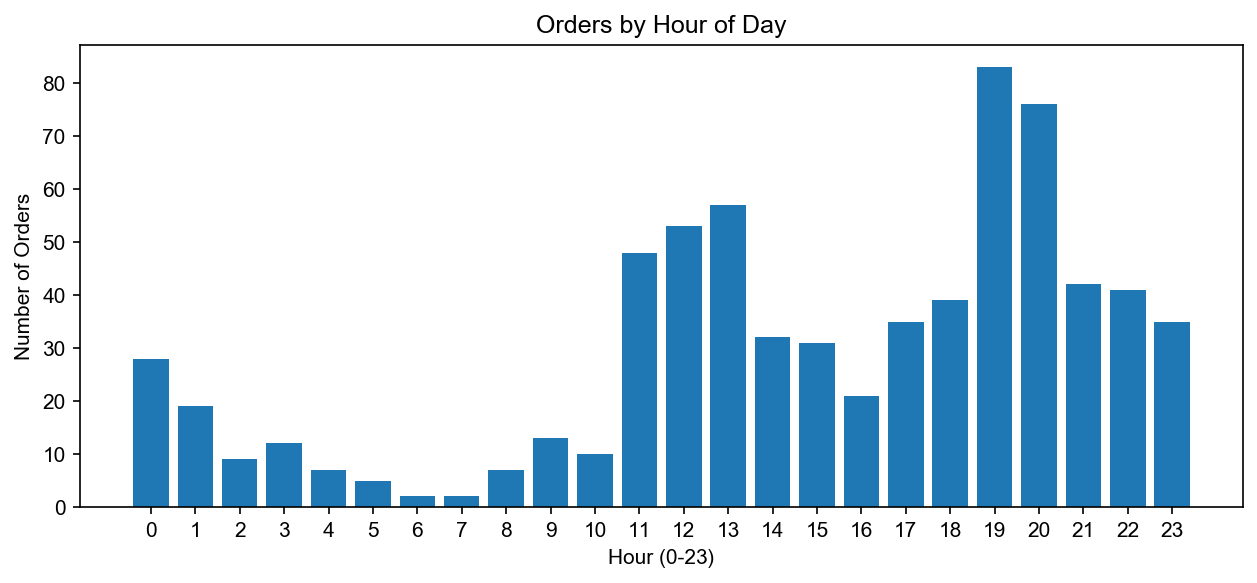

In [84]:
result2 = eda_agent(
    query="tell me about the data and find something interesting",
    df=df_eleme,
    use_reflection=True,
    include_viz=True
)

📊 EDA Agent Processing: tell me about the data and find something interesting

🔄 Generating V1 code...
⚙️  Executing V1 code...
✅ V1 execution successful

🤔 Reflecting on V1 results...
⚙️  Executing V2 code...
✅ V2 execution successful
Preparing final report

📊 FINAL RESULT
Summary of the data
- Dataset: 707 orders, 13 columns, order timestamps spanning 2022-11-03 to 2025-11-02.
- Core numeric summaries:
  - Average order amount: ¥38.45; median ¥30.00.
  - Order amounts range from ¥0.00 to ¥462.41; 46 orders are zero or negative.
  - Average items per order: 2.35; median 2; maximum 112 (one outlier).
- Missingness: most columns complete. "商品描述" and "订单子类型" are almost entirely empty (705 missing), "收货人" missing 18, "地址" missing 33.

Key patterns and interesting findings
- Peak ordering hour: 19:00 (7 PM) with 83 orders; other high-traffic hours are 20:00 (76), 13:00 (57), 12:00 (53) and 11:00 (48). Late evening and lunch are the busiest periods.
- Top merchants by order count:
  - 老广烧腊(

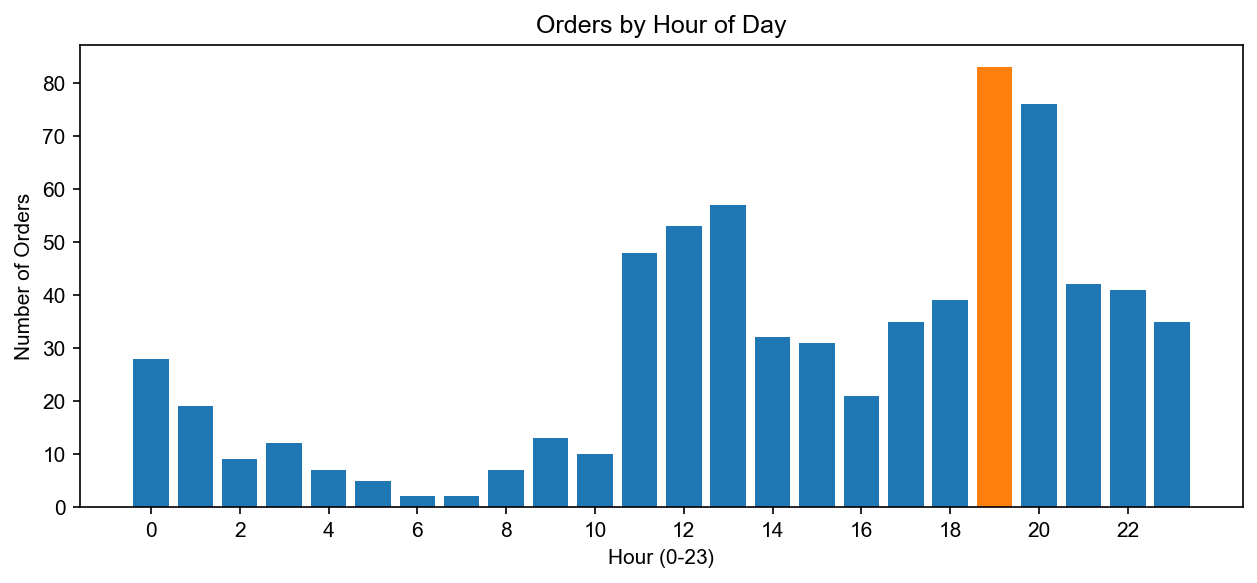

In [410]:
result2 = eda_agent(
    query="tell me about the data and find something interesting",
    df=df_eleme,
    use_reflection=True,
    include_viz=True
)

📊 EDA Agent Processing: 从这份数据里有什么有趣发现？

🔄 Generating V1 code...
⚙️  Executing V1 code...
❌ V1 Error:
Traceback (most recent call last):
  File "/var/folders/f4/n64j5lvd2gb_tm4kxbd55qsc0000gn/T/ipykernel_80965/2867080774.py", line 32, in execute_code
    exec(code, namespace)
  File "<string>", line 47, in <module>
  File "/Users/tylerxie/airepo/edaagent/.venv/lib/python3.12/site-packages/pandas/core/generic.py", line 6321, in __getattr__
    return object.__getattribute__(self, name)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'Series' object has no attribute 'iteritems'


🤔 Reflecting on V1 results...
⚙️  Executing V2 code...
✅ V2 execution successful
Preparing final report

📊 FINAL RESULT


<string>:15: SyntaxWarning: invalid escape sequence '\s'


总结要点（简短）：

- 热销品：销量最高的是“满足任意双拼饭”（89份），其次是“嫩烤鸡胸·时蔬暖沙拉”（43）和两种表述的“无需/环保不需要餐具”（41、39）。前十名主要是主食与配菜/加项混合。
- 下单时段：订单在午餐与晚餐高峰明显，11点-13点最高（11点48，12点53，13点57），晚高峰19点（83）与20点（76）也很高；凌晨/清晨时段（0–6点）订单显著较少。
- 客单价与状态：已完成订单（677单）平均交易额约37.78元；已关闭订单（24单）平均较高约61.62元（可能包含大额异常或退款前取消）；已退款样本少（6单），均价约21.18元。
- 收货人分布：“谢(先生)”相关为多数（共约660次合并计），其它收件人远少于此，说明收货人集中在少数几位。
- 异常订单：检测到63个异常/离群订单（可能是极端数量或金额），需进一步人工核查。

有趣发现 / 建议关注点：
- “无需餐具/环保”项频繁出现，表明用户对不需要餐具选项接受度高，可考虑在包装/营销上突出环保选项。
- 高额已关闭订单平均值偏高，建议核查这些关闭订单的原因（大额误单、退单或配送问题）。
- 收货人高度集中，若是企业/团购账户可优化对接；若为个人应检查是否合并了同一人多种写法。
- 晚餐19-20点峰值与午餐11-13点峰值明显，建议根据峰值调整备货与配送资源。

可视化说明：
- 提供的横向条形图展示了按累计数量排序的前10个品项，条长直观显示“满足任意双拼饭”显著领先其余品项。

📈 Visualization: output/v2_plot.png


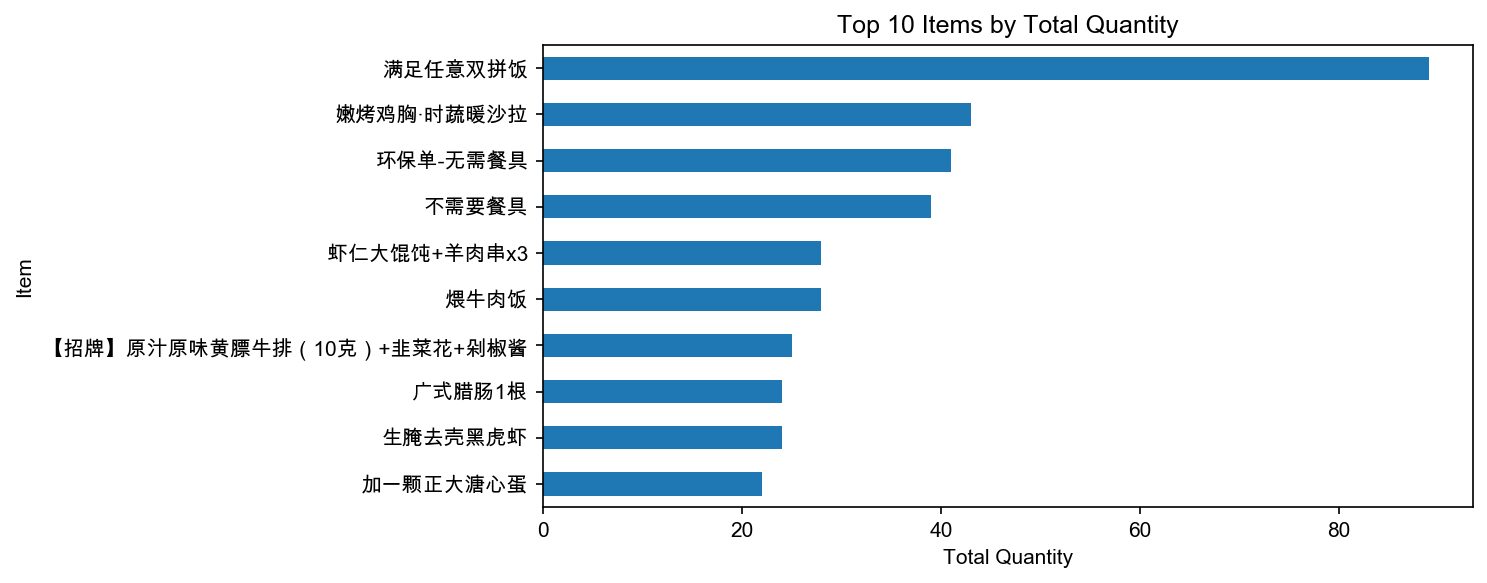

In [98]:
result3 = eda_agent(
    query="从这份数据里有什么有趣发现？",
    df=df_eleme,
    use_reflection=True,
    include_viz=True
)

📊 EDA Agent Processing: 这一份是什么数据？

🔄 Generating V1 code...
⚙️  Executing V1 code...
✅ V1 execution successful

🤔 Reflecting on V1 results...
⚙️  Executing V2 code...
❌ V2 Error:
Traceback (most recent call last):
  File "/var/folders/f4/n64j5lvd2gb_tm4kxbd55qsc0000gn/T/ipykernel_80965/2867080774.py", line 32, in execute_code
    exec(code, namespace)
  File "<string>", line 25
    s_clean = s.str.replace(r"[^
                            ^
SyntaxError: unterminated string literal (detected at line 25)

⚠️  Using V1 results as fallback
Preparing final report

📊 FINAL RESULT
这是对数据的简要说明与关键发现：

- 数据类型：餐饮外卖订单数据（订单记录）。
- 时间范围：2022-11-03 12:40:19 到 2025-11-02 19:21:27。
- 记录规模：共 707 条订单，涉及 236 个不同商户，收货人数量为 8 人。
- 订单金额统计：
  - 平均订单金额约 38.45 元；
  - 中位数为 30.00 元；
  - 订单金额分布右偏（长尾），大多数订单集中在较低金额区间（0–60 元），但存在少数较高金额的异常值（200、300、400+ 元）。
- 可解读的业务含义：
  - 典型外卖订单金额偏低，消费以 30 元 左右为常态；
  - 少数高额订单可能为大单或拼单/团体订餐，建议对这些异常高额订单进一步核查（是否为退款/折扣/系统录入）。
- 可视化说明：所给直方图显示订单金额分布，条形高度代表该金额区间的订单频次，可见左侧（低金额）频次最高，右侧有稀疏的高额订单点。

如

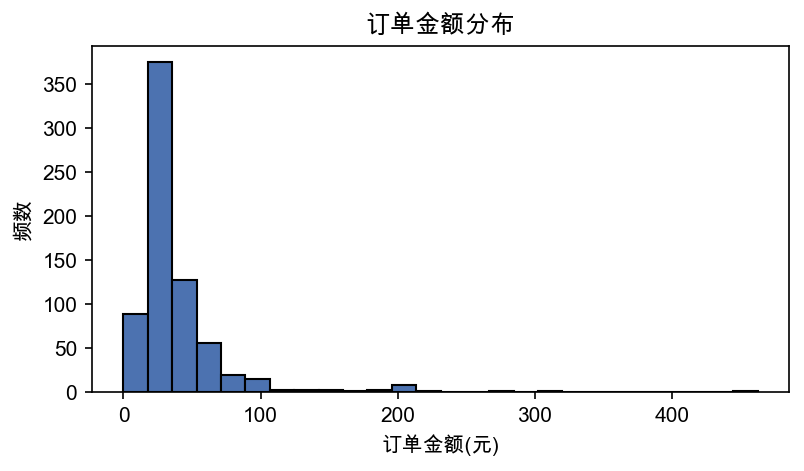

In [99]:
result4 = eda_agent(
    query="这一份是什么数据？",
    df=df_eleme,
    use_reflection=True,
    include_viz=True
)

## Eval

In [61]:
def judge_result(
    question,
    agent_result,
    reference_answer,
    category = None
):
    """
    Use LLM to judge agent result against reference answer.
    
    Args:
        question: Original evaluation question
        agent_result: Result from eda_agent
        reference_answer: Ground truth answer
        category: Optional question category
        
    Returns:
        Dictionary with:
            - score: 0-5 rating
            - reasoning: Explanation of the score
    """
    system_prompt = """You are an expert evaluator for data analysis tasks.

Your task:
- Compare the agent's analysis result to the reference answer
- Judge correctness, completeness, and insight quality
- Judge language matching: the response language should match the query language (English query → English response, Chinese query → Chinese response)
- Assign a score from 0-5:
  * 5: Perfect - accurate, complete, insightful
  * 4: Good - mostly accurate with minor gaps
  * 3: Acceptable - correct direction but incomplete
  * 2: Poor - some relevance but major issues
  * 1: Bad - mostly incorrect or irrelevant
  * 0: Failed - completely wrong or no useful output

Return ONLY valid JSON:
{
  "score": <0-5>,
  "reasoning": "<brief explanation>"
}
"""
    
    category_info = f"\nCategory: {category}" if category else ""
    
    # Extract key info from agent result
    agent_summary = agent_result.get("result_summary", "")
    agent_data = agent_result.get("final_result", {}).get("result", "")
    
    user_prompt = f"""Question:
{question}{category_info}

Reference Answer:
{reference_answer}

Agent Result Summary:
{agent_summary}

Agent Result Data:
{agent_data}

Evaluate the agent's performance."""
    
    response = get_response(
        system_prompt=system_prompt,
        user_prompt=user_prompt,
        image_path=agent_result.get("final_result", {}).get("image_path")
    )
    
    # Parse JSON response
    try:
        result = json.loads(response)
    except Exception:
        # Try to extract JSON from response
        match = re.search(r'\{.*\}', response, re.DOTALL)
        result = json.loads(match.group(0)) if match else {
            "score": 0,
            "reasoning": f"Parse error: {response}"
        }
    
    return result


def _sanitize_for_json(obj):
    """
    Recursively convert objects to JSON-serializable format.
    Handles date objects, numpy types, DataFrames, etc.
    """
    import datetime
    import numpy as np
    
    # Handle DataFrame and Series first
    if isinstance(obj, pd.DataFrame):
        return obj.to_dict(orient='records')
    elif isinstance(obj, pd.Series):
        return obj.to_dict()
    elif isinstance(obj, dict):
        return {str(k): _sanitize_for_json(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [_sanitize_for_json(item) for item in obj]
    elif isinstance(obj, (datetime.date, datetime.datetime)):
        return obj.isoformat()
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif obj is None:
        return None
    elif pd.api.types.is_scalar(obj):
        if pd.isna(obj):
            return None
        else:
            return obj
    else:
        return obj


def run_evaluation(
    df_eval,
    df_data,
    output_dir = "./eval_output",
    use_reflection = True,
    include_viz = True,
    save_results = True
):
    """
    Run full evaluation pipeline.
    
    Args:
        df_eval: DataFrame with evaluation questions
        df_data: DataFrame to analyze
        output_dir: Directory for outputs
        use_reflection: Enable reflection in eda_agent
        include_viz: Enable visualizations
        save_results: Save detailed results to JSON
        
    Returns:
        Dictionary with:
            - results: List of individual eval results
            - summary: Aggregate metrics
    """
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    results = []
    
    print("=" * 70)
    print("STARTING EVALUATION")
    print("=" * 70)
    print(f"Questions: {len(df_eval)}")
    print(f"Output dir: {output_dir}\n")
    
    for idx, row in df_eval.iterrows():
        q_id = row.get("Question_ID", idx)
        category = row.get("Category", "Unknown")
        question = row["Question"]
        reference = row["Answer"]
        
        print(f"\n{'='*70}")
        print(f"Question {q_id}/{len(df_eval)}: {category}")
        print(f"{'='*70}")
        print(f"Q: {question}\n")
        
        # Run agent
        try:
            agent_result = eda_agent(
                query=question,
                df=df_data,
                use_reflection=use_reflection,
                include_viz=include_viz,
                output_dir=str(output_path / f"q{q_id}")
            )
            
            # Judge result
            print("\n🔍 Judging result...")
            judgment = judge_result(
                question=question,
                agent_result=agent_result,
                reference_answer=reference,
                category=category
            )
            
            # Display judgment
            score = judgment["score"]
            passed = score >= 3
            status = "✅ PASSED" if passed else "❌ FAILED"
            print(f"\n{status} - Score: {score}/5")
            print(f"Reasoning: {judgment['reasoning']}")
            
        except Exception as e:
            print(f"\n❌ ERROR: {str(e)}")
            agent_result = {"error": str(e)}
            judgment = {
                "score": 0,
                "reasoning": f"Execution error: {str(e)}"
            }
            score = 0
        
        # Store result
        results.append({
            "question_id": q_id,
            "category": category,
            "question": question,
            "reference_answer": reference,
            "agent_result": agent_result,
            "judgment": judgment,
            "score": score
        })
    
    # Calculate summary metrics
    scores = [r["score"] for r in results]
    passed_count = sum(1 for r in results if r["score"] >= 3)
    
    summary = {
        "total_questions": len(results),
        "passed": passed_count,
        "failed": len(results) - passed_count,
        "pass_rate": passed_count / len(results) if results else 0,
        "avg_score": sum(scores) / len(scores) if scores else 0,
        "score_distribution": {
            str(i): scores.count(i) for i in range(6)
        }
    }
    
    # Print summary
    print("\n" + "=" * 70)
    print("EVALUATION SUMMARY")
    print("=" * 70)
    print(f"Total Questions: {summary['total_questions']}")
    print(f"Passed: {summary['passed']} ({summary['pass_rate']:.1%})")
    print(f"Failed: {summary['failed']}")
    print(f"Average Score: {summary['avg_score']:.2f}/5")
    print(f"\nScore Distribution:")
    for score, count in sorted(summary['score_distribution'].items()):
        print(f"  {score}: {'█' * count} ({count})")
    
    # Save results
    if save_results:
        results_file = output_path / "eval_results.json"
        with open(results_file, 'w', encoding='utf-8') as f:
            # Sanitize data before saving to handle date objects and numpy types
            sanitized_data = _sanitize_for_json({
                "summary": summary,
                "results": results
            })
            json.dump(sanitized_data, f, indent=2, ensure_ascii=False)
        print(f"\n💾 Results saved to: {results_file}")
    
    return {
        "results": results,
        "summary": summary
    }


def print_eval_report(eval_results):
    """
    Print detailed evaluation report.
    
    Args:
        eval_results: Output from run_evaluation
    """
    summary = eval_results["summary"]
    results = eval_results["results"]
    
    print("=" * 70)
    print("DETAILED EVALUATION REPORT")
    print("=" * 70)
    
    # Group by category
    by_category = {}
    for r in results:
        cat = r["category"]
        if cat not in by_category:
            by_category[cat] = []
        by_category[cat].append(r)
    
    for category, items in by_category.items():
        scores = [item["score"] for item in items]
        passed = sum(1 for item in items if item["score"] >= 3)
        
        print(f"\n{category}:")
        print(f"  Questions: {len(items)}")
        print(f"  Passed: {passed}/{len(items)} ({passed/len(items):.1%})")
        print(f"  Avg Score: {sum(scores)/len(scores):.2f}/5")
        
        for item in items:
            status = "✅" if item["score"] >= 3 else "❌"
            print(f"    {status} Q{item['question_id']}: {item['score']}/5 - {item['question'][:50]}...")
    
    print("\n" + "=" * 70)

In [58]:
# Load evaluation data
df_eval = load_data("../data/eval_eleme.xlsx")
df_eval.head()

✓ Loaded data: 10 rows × 7 columns


,Question_ID,Category,Question,Description,Relevant_Columns,Answer,Eval_result_minimal
0,1,Customer Behavior,What are the peak ordering times?,Analyze order time to identify daily patterns ...,下单时间,"Peak ordering hours are 7PM (83 orders), 8PM (...",pass
1,2,Customer Behavior,What is the customer retention pattern?,How frequently does the main customer order? W...,"下单时间, 收货人",The main customer placed 662 orders over the p...,"got wrong no. of users, did not clean and merg..."
2,3,Customer Behavior,What is the average order value and spending t...,Calculate total spending and average basket si...,"订单金额(元), 下单时间",Average order value is ¥38.45. Total spending ...,pass
3,4,Merchant & Product,Which merchants are most popular and what is t...,Identify top merchants by order frequency and ...,"商户信息, 订单号","Top merchants: 老广烧腊(盈创店) with 116 orders, 麦田归来...",output answer in chinese
4,5,Merchant & Product,What are the most frequently ordered product c...,Classify products (e.g. noodles and rice bowls...,"商品及数量, 商户信息",Requires product classification analysis. Main...,output answer in chinese


📊 EDA Agent Processing: What are the most frequently ordered product categories?

🔄 Generating V1 code...
⚙️  Executing V1 code...
✅ V1 execution successful

🤔 Reflecting on V1 results...
⚙️  Executing V2 code...
✅ V2 execution successful
Preparing final report

📊 FINAL RESULT
Summary of findings:

- There are 838 unique products in the dataset.
- The top 10 most frequently ordered items are heavily skewed toward a few
  entries. Counts for the top items:
  - Item labeled "1": 701 orders (by far the highest)
  - Item labeled "2": 373 orders
  - Item labeled "3": 140 orders
  - 商品:满足任意双拼饭: 89 orders
  - Item labeled "4": 54 orders
  - 商品:嫩烤鸡胸·时蔬暖沙拉: 43 orders
  - 商品:环保单-无需餐具: 41 orders
  - 商品:不需要餐具: 39 orders
  - 数量:1 (appears as a product-like value): 30 orders
  - 商品:煨牛肉饭: 28 orders

Key insights:
- A very small number of entries account for a large share of orders (the top 2
  items alone total 1,074 orders).
- Some of the top entries appear to be non-standard product labels or utili

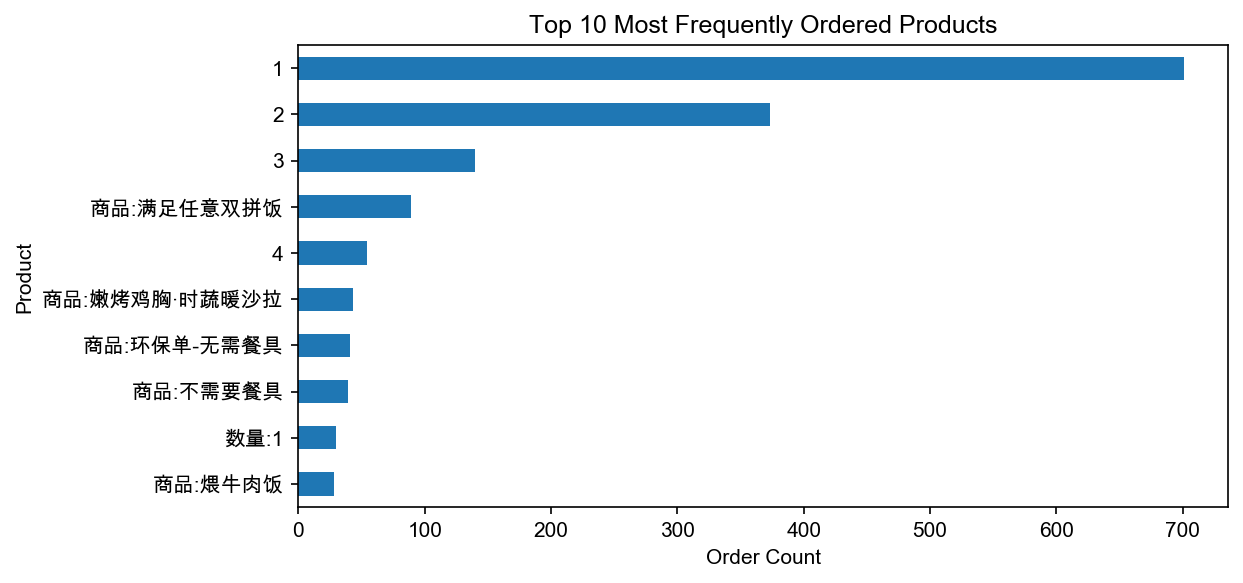


Score: 4/5
Reasoning: Mostly correct and useful: the agent identified top items,
highlighted data quality issues (non-product labels) and recommended cleaning,
which matches the reference need for product classification. Minor gaps: it
didn't aggregate into higher-level categories (roasted meats, rice, noodles,
combos) as the reference suggested, and language mixing of some labels could be
normalized. Overall accurate with helpful insight.


In [65]:
single_question = df_eval.iloc[4]

agent_result = eda_agent(
    query=single_question["Question"],
    df=df_eleme,
    use_reflection=True,
    include_viz=True
)

judgment = judge_result(
    question=single_question["Question"],
    agent_result=agent_result,
    reference_answer=single_question["Answer"],
    category=single_question["Category"]
)

print(f"\nScore: {judgment['score']}/5")
print_wrapped(f"Reasoning: {judgment['reasoning']}")

STARTING EVALUATION
Questions: 10
Output dir: ./eval_output


Question 1/10: Customer Behavior
Q: What are the peak ordering times?

📊 EDA Agent Processing: What are the peak ordering times?

🔄 Generating V1 code...
⚙️  Executing V1 code...
✅ V1 execution successful

🤔 Reflecting on V1 results...
⚙️  Executing V2 code...
✅ V2 execution successful
Preparing final report

📊 FINAL RESULT
Summary of findings:

- Total orders analyzed: 707.
- Orders are distributed across the day with clear peaks in the evening and
  early afternoon.
- Peak hours (highest order counts):
  - 19:00 — 83 orders (highest)
  - 20:00 — 76 orders (second highest)
  - 13:00 — 57 orders (third highest)
- Other notable high-volume hours: 12:00 (53), 11:00 (48), 21:00 (42), 22:00
  (41), 23:00 (35), 17:00 (35).
- Low-volume hours: early morning between 4:00–8:00 (counts mostly single digits
  to low teens).

Visualization explanation:
- The bar chart shows number of orders per hour (0–23). Taller bars indicate
  busie

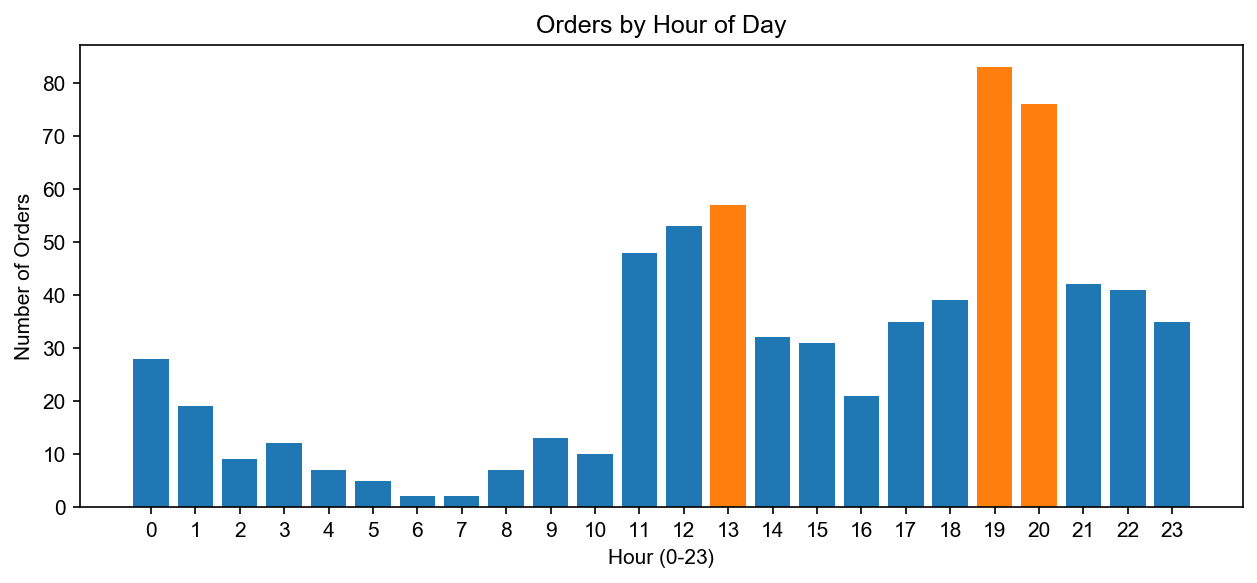


🔍 Judging result...

✅ PASSED - Score: 5/5
Reasoning: Agent results match the reference exactly: identified peak hours 19:00 (83), 20:00 (76), and 13:00 (57), provided supporting hourly counts, total orders, and concise interpretation. Clear, complete, and accurate.

Question 2/10: Customer Behavior
Q: What is the customer retention pattern?

📊 EDA Agent Processing: What is the customer retention pattern?

🔄 Generating V1 code...
⚙️  Executing V1 code...
✅ V1 execution successful

🤔 Reflecting on V1 results...
⚙️  Executing V2 code...
✅ V2 execution successful
Preparing final report

📊 FINAL RESULT


<string>:22: SyntaxWarning: invalid escape sequence '\|'


Summary of findings — customer retention pattern

- Overall shape: retention is highest in the first two weeks (week 0 and 1 =
  100%) and then drops, stabilizing around ~65–80% from week 2 onward with some
  fluctuations.
- Key numbers (average retention by week):
  - Week 0–1: 1.00 (all customers present the first week and the next).
  - Week 2–3: declines to ~0.86 (wk2) and 0.80 (wk3).
  - Week 4: lowest point at ~0.63.
  - Weeks 5–8: rebound to ~0.73–0.78.
  - Weeks 9–12: range ~0.67–0.78, ending at ~0.67 by week 12.
- Interpretation:
  - There is an initial drop after week 1, a trough around week 4, then partial
  recovery and relative stabilization. This suggests most churn happens early
  (weeks 2–4), after which a core of customers remains reasonably stable.
  - Long-term retention (up to week 12) holds generally between about two-thirds
  and three-quarters of customers on average.
- Cohort coverage: 34 cohorts were analyzed and retention was computed up to 102
  weeks for som

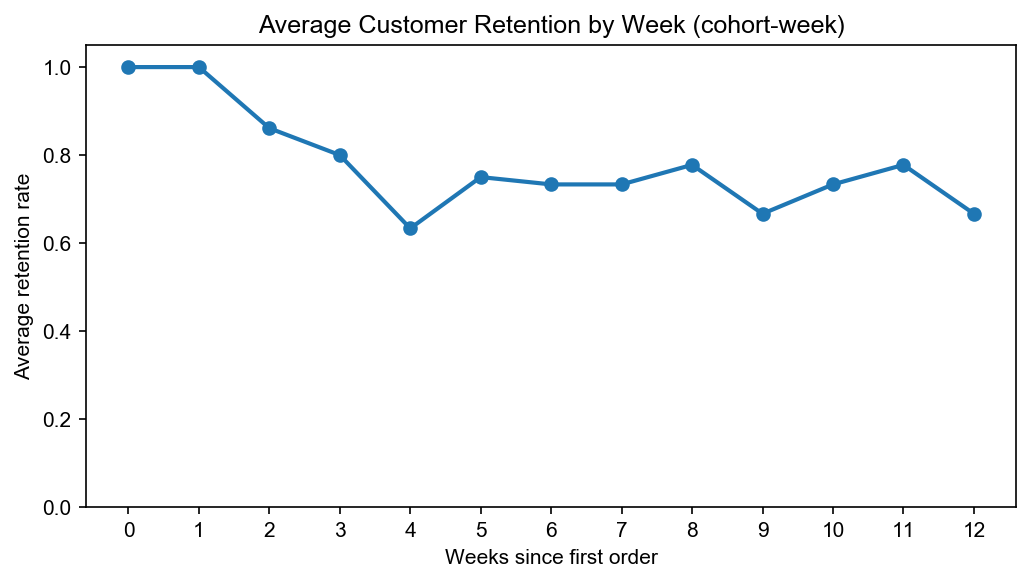


🔍 Judging result...

✅ PASSED - Score: 4/5
Reasoning: The agent's summary accurately describes the retention shape (100% initial, drop around weeks 2–4, recovery and stabilization ~65–80% through week 12) and provides correct week-by-week numbers matching the data. It also notes cohort count and max weeks. Missing: it doesn't mention the reference's specific single-customer statistic (662 orders, 1.66 days between orders) — but that was a different focus. Overall correct and clear with minor omission relative to the reference.

Question 3/10: Customer Behavior
Q: What is the average order value and spending trend over time?

📊 EDA Agent Processing: What is the average order value and spending trend over time?

🔄 Generating V1 code...
⚙️  Executing V1 code...
❌ V1 Error:
Traceback (most recent call last):
  File "/Users/tylerxie/airepo/edaagent/.venv/lib/python3.12/site-packages/pandas/core/window/rolling.py", line 371, in _prep_values
    values = ensure_float64(values)
             ^

<string>:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



❌ ERROR: Invalid \escape: line 3 column 1048 (char 1833)

Question 5/10: Merchant & Product
Q: What are the most frequently ordered product categories?

📊 EDA Agent Processing: What are the most frequently ordered product categories?

🔄 Generating V1 code...
⚙️  Executing V1 code...
✅ V1 execution successful

🤔 Reflecting on V1 results...
⚙️  Executing V2 code...
❌ V2 Error:
Traceback (most recent call last):
  File "/var/folders/f4/n64j5lvd2gb_tm4kxbd55qsc0000gn/T/ipykernel_98046/2867080774.py", line 32, in execute_code
    exec(code, namespace)
  File "<string>", line 69, in <module>
  File "/Users/tylerxie/airepo/edaagent/.venv/lib/python3.12/site-packages/pandas/core/frame.py", line 782, in __init__
    mgr = dict_to_mgr(data, index, columns, dtype=dtype, copy=copy, typ=manager)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/tylerxie/airepo/edaagent/.venv/lib/python3.12/site-packages/pandas/core/internals/construction.py", line 503,

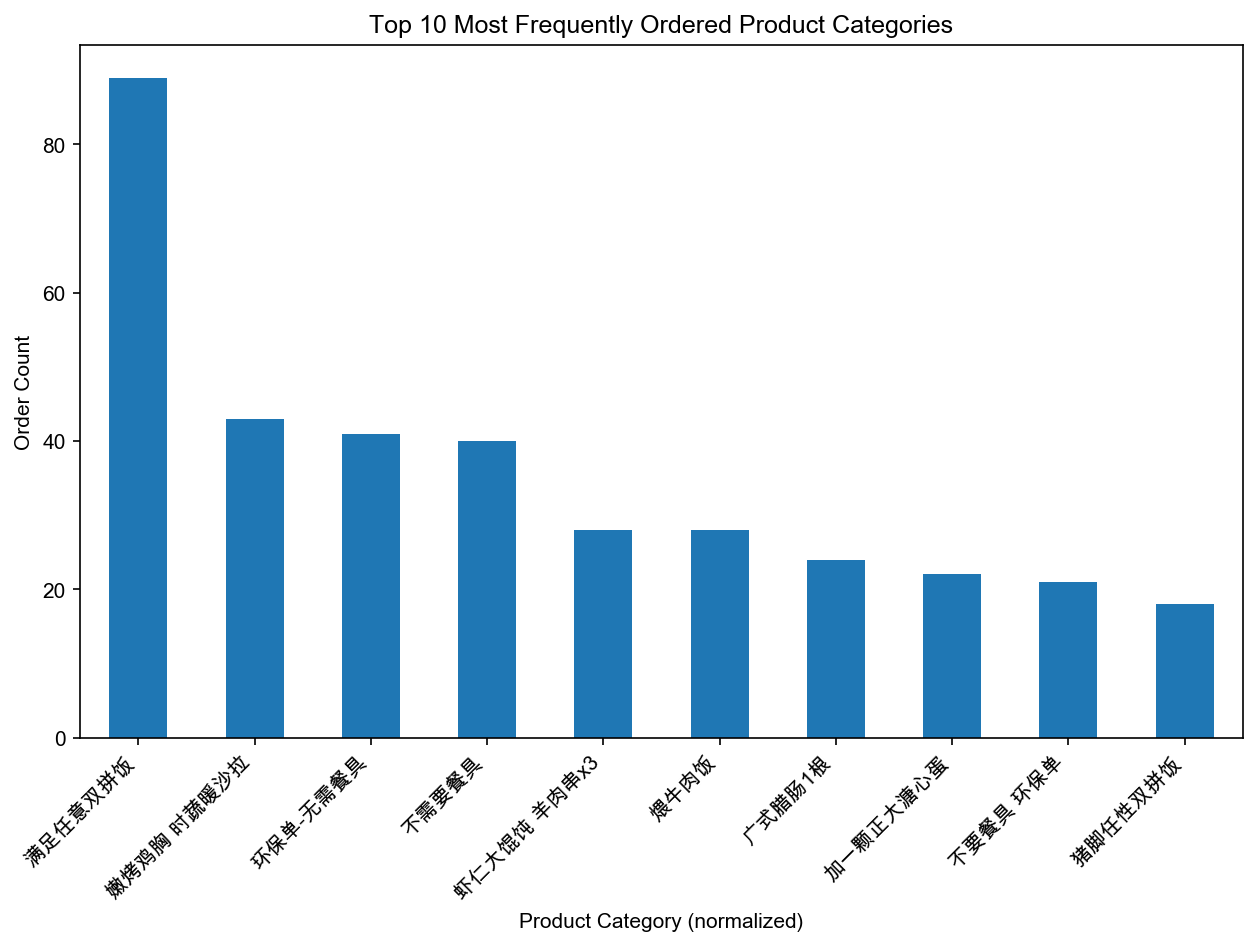


🔍 Judging result...

✅ PASSED - Score: 3/5
Reasoning: The agent extracted top items and counts correctly from the dataset and noted useful operational insight (no-cutlery labels). However it reported item-level SKUs rather than high-level product categories requested by the question (roasted meats, rice bowls, noodles, combos). It didn't perform the required product classification/grouping (only suggested doing so), so the result is directionally useful but incomplete.

Question 6/10: Merchant & Product
Q: Which merchants have the highest/lowest refund or cancellation rates?

📊 EDA Agent Processing: Which merchants have the highest/lowest refund or cancellation rates?

🔄 Generating V1 code...
⚙️  Executing V1 code...
✅ V1 execution successful

🤔 Reflecting on V1 results...
⚙️  Executing V2 code...
✅ V2 execution successful
Preparing final report

📊 FINAL RESULT
总结要点（中文）：

- 退款/取消率最高的商户：
  - 汉堡王本地生活店：5笔订单中有4笔退款，退款率为80%（样本量很小，需谨慎解读）。
  - 麦田归来本地生活店：8笔订单中1笔退款，退款率12.5%。

- 退款/取消率最低的商户（0%）：

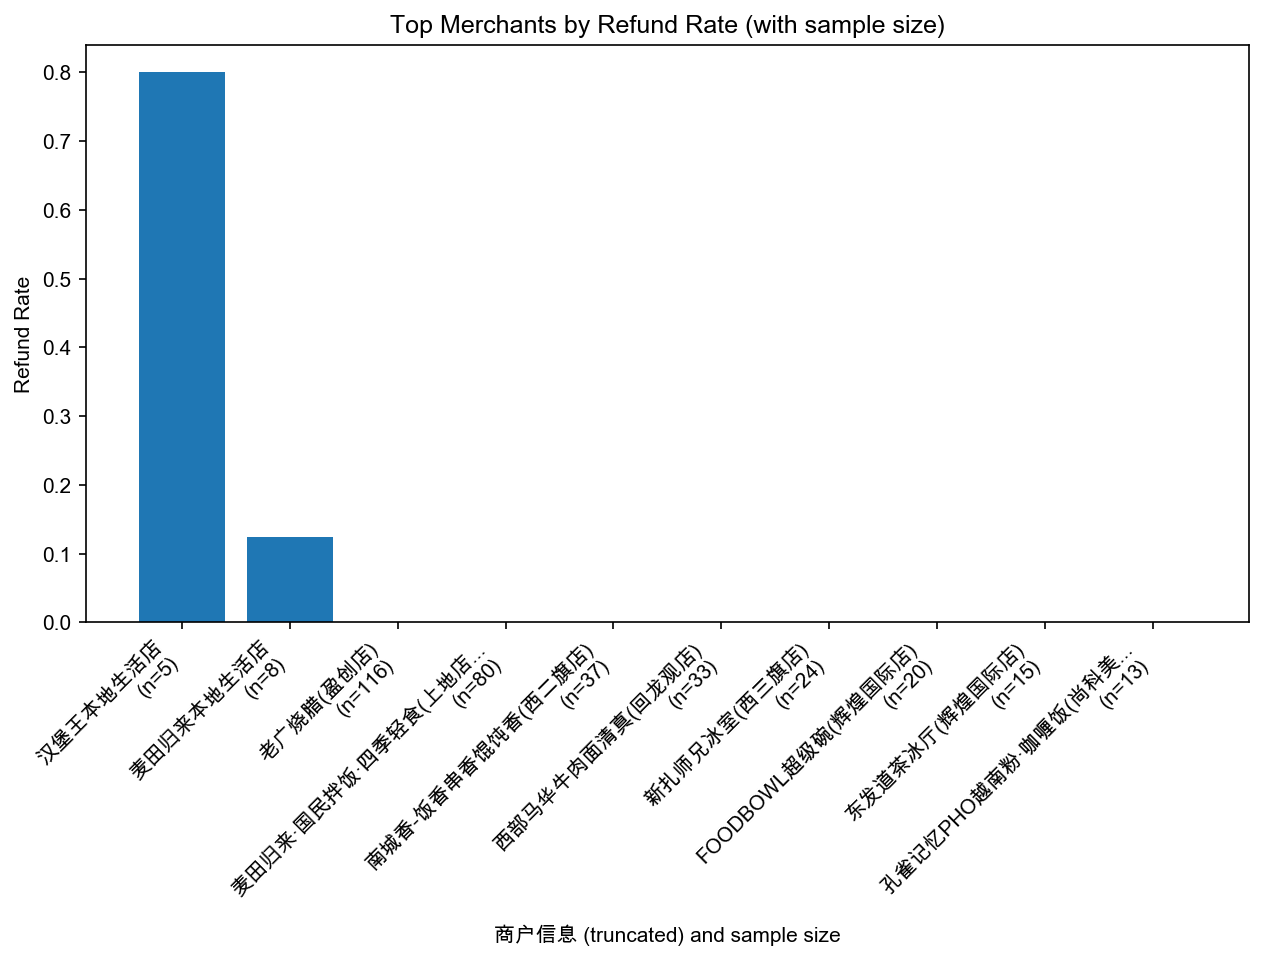


🔍 Judging result...

✅ PASSED - Score: 4/5
Reasoning: Agent identified merchants with highest and lowest refund rates, provided counts, rates, cautions about small sample sizes, and suggested focusing on larger-sample merchants—matching the reference need for merchant-level failure analysis. Minor issues: the agent's 'highest' list includes several 0% entries and duplicates the same merchants across highest/lowest lists, and it didn't explicitly mention analyzing the 24 closed and 6 refunded orders as the reference stated. Otherwise accurate and useful.

Question 7/10: Operational
Q: What is the relationship between delivery address and order frequency?

📊 EDA Agent Processing: What is the relationship between delivery address and order frequency?

🔄 Generating V1 code...
⚙️  Executing V1 code...
✅ V1 execution successful

🤔 Reflecting on V1 results...
⚙️  Executing V2 code...
✅ V2 execution successful
Preparing final report

📊 FINAL RESULT
语言：中文

总结：
- 数据包含674单、42个不同交付地址。
- 订单高度集中：西二

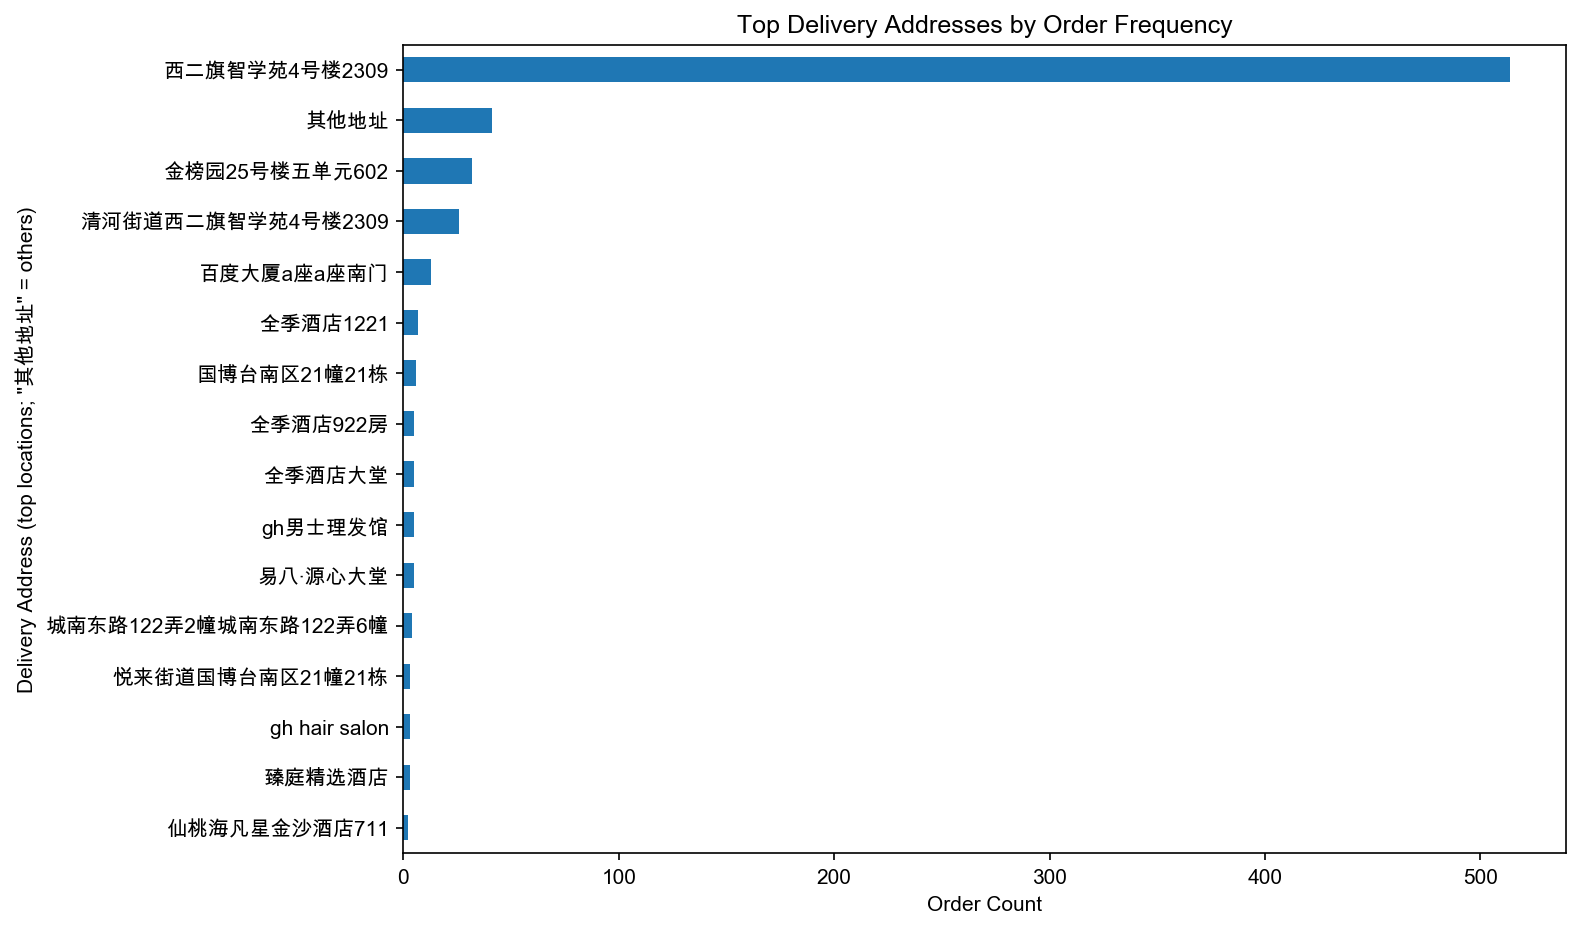


🔍 Judging result...

✅ PASSED - Score: 4/5
Reasoning: Mostly accurate and useful: agent correctly identifies a strong concentration at a single address and provides counts/percentages and actionable insights. Minor issues: agent reports 42 unique addresses vs reference 46 (small discrepancy) and total orders 674 vs reference unspecified but likely matching; could've noted need to classify addresses (home vs office) as reference suggests. Language matches (Chinese).

Question 8/10: Operational
Q: How many orders request no utensils?

📊 EDA Agent Processing: How many orders request no utensils?

🔄 Generating V1 code...
⚙️  Executing V1 code...
✅ V1 execution successful

🤔 Reflecting on V1 results...
⚙️  Executing V2 code...
✅ V2 execution successful
Preparing final report

📊 FINAL RESULT


<string>:23: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
<string>:23: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
<string>:23: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


Summary of findings:

- Number of orders requesting no utensils: 128.
- Total orders analyzed: 707.
- Share of orders requesting no utensils: 18.1%.
- Orders that did request utensils: 579 (81.9%).

Visualization explanation:
- The bar chart compares counts for "No Utensils" (128, labeled with 18.1%) and
  "With Utensils" (579). It highlights that the majority of orders include
  utensils, while about one in five opt out.

📈 Visualization: eval_output/q8/v2_plot.png


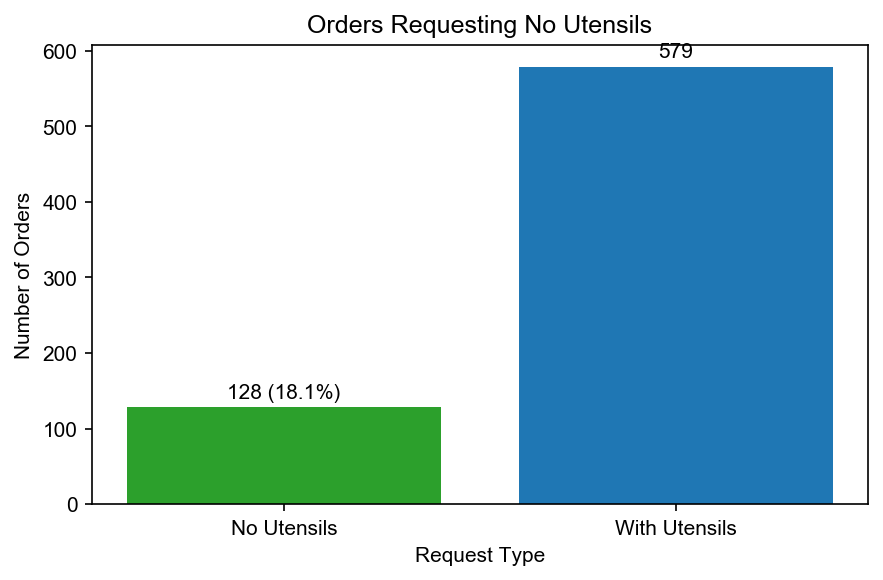


🔍 Judging result...

✅ PASSED - Score: 5/5
Reasoning: Agent's result matches the reference exactly: 128 orders requested no utensils. Reported counts, percentages, and totals are consistent and the summary and visualization explanation are correct.

Question 9/10: Operational
Q: What is the order failure rate and why?

📊 EDA Agent Processing: What is the order failure rate and why?

🔄 Generating V1 code...
⚙️  Executing V1 code...
✅ V1 execution successful

🤔 Reflecting on V1 results...
⚙️  Executing V2 code...


<string>:17: SyntaxWarning: invalid escape sequence '\s'


✅ V2 execution successful
Preparing final report

📊 FINAL RESULT
Summary:
- Overall order failure rate: 6 failed orders out of 707 total = 0.85%
  (~0.0085).
- Failures are rare and concentrated: one month (2025-08) shows a higher monthly
  spike (~14.63% for that month), all other months show 0% in the plotted
  period.
- Top merchants by volume mostly had zero failures; one smaller merchant
  (麦田归来本地生活店) had 1 failure out of 8 orders (12.5%).

Key insights / likely causes:
- Missing recipient or address information strongly correlates with higher
  failure rates:
  - Orders missing recipient: 18 orders, 1 failed -> 5.56% failure vs 0.73% when
  recipient present.
  - Orders missing address: 33 orders, 6 failed -> 18.18% failure; no failures
  when address present.
- Failed orders have lower order values on average (median ~19.8, mean ~21.18)
  than successful orders (median 30, mean ~38.59), suggesting small-value orders
  are more likely to be canceled or have payment problems.
- Or

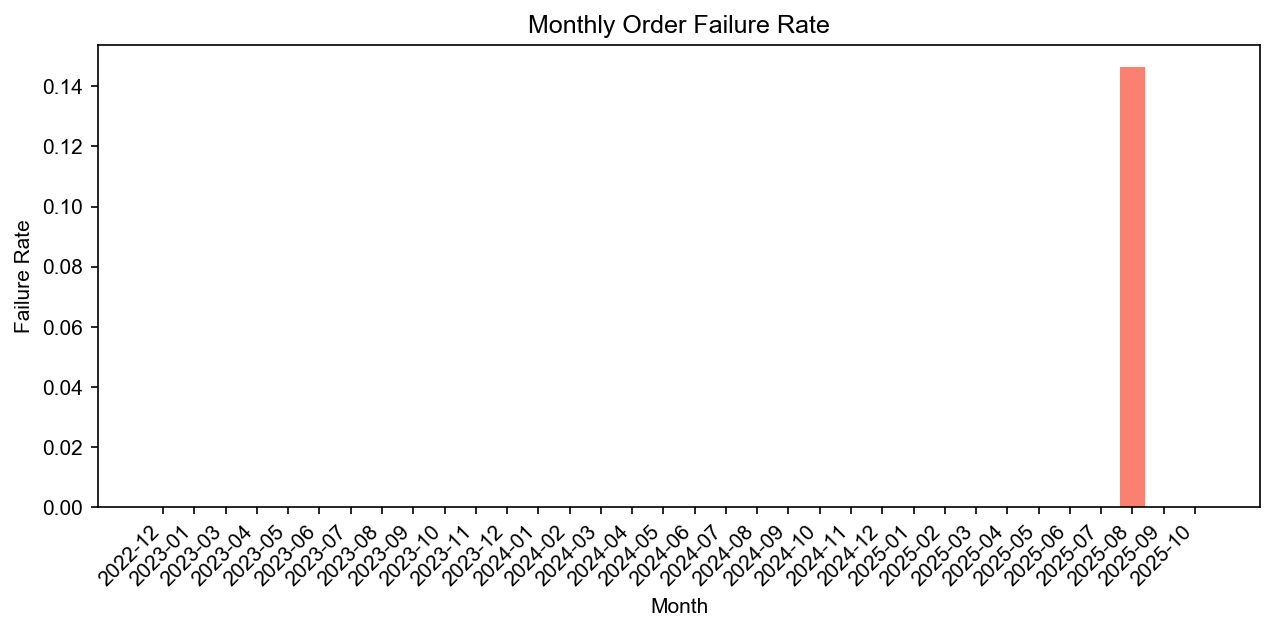


🔍 Judging result...

❌ FAILED - Score: 2/5
Reasoning: The agent's analysis is partly relevant but incorrect on the primary metric: it reports 6 failed orders (0.85%) while the reference states 30 failures (4.24%). The agent did correctly summarize patterns (spike in Aug 2025, correlations with missing address/recipient, lower amounts for failures) and gave reasonable recommendations, but the core failure-count/rate is seriously underreported, making the conclusion about overall failure rate wrong. Language matches (Chinese merchant names included), but completeness and accuracy are insufficient.

Question 10/10: Business Intelligence
Q: What is the Customer Lifetime Value (CLV) and ordering forecast?

📊 EDA Agent Processing: What is the Customer Lifetime Value (CLV) and ordering forecast?

🔄 Generating V1 code...
⚙️  Executing V1 code...
✅ V1 execution successful

🤔 Reflecting on V1 results...


<string>:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
<string>:45: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


⚙️  Executing V2 code...
✅ V2 execution successful
Preparing final report

📊 FINAL RESULT


<string>:75: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
<string>:78: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


Summary (English):

Method
- CLV estimated as: average order value × annual purchase frequency × expected
  years, where expected_years = 1 + 2 × recency_weight (per analysis).

Top CLV customers (proxy)
- Highest proxies: one customer labeled "谢(先生)|西二旗智学苑4号楼2309请放门口" ~13,280;
  second "谢(先生)|西二旗智学苑4号楼2309" ~5,037.
- Other notable CLV proxies range ~2,725 down to ~435. Top customers have high
  order counts and/or high total monetary value.

Monthly history (key patterns)
- Orders grew overall from 2022 into mid‑2025 with volatility.
- Several peaks: late 2024 (37–42 orders), strong growth in mid‑2025 (May–Jul
  2025: 31, 45, 56, 61 orders; peak ~61 orders), then a drop and noisy months
  afterward.
- Revenue generally tracks orders; highest monthly revenues align with the
  high‑order months in 2024–2025.

Forecast
- Order forecast for the next three month-ends:
  - 2025-12-31: ~34.6 orders
  - 2026-01-31: ~35.4 orders
  - 2026-02-28: ~36.2 orders
- Forecast indicates a modest upward

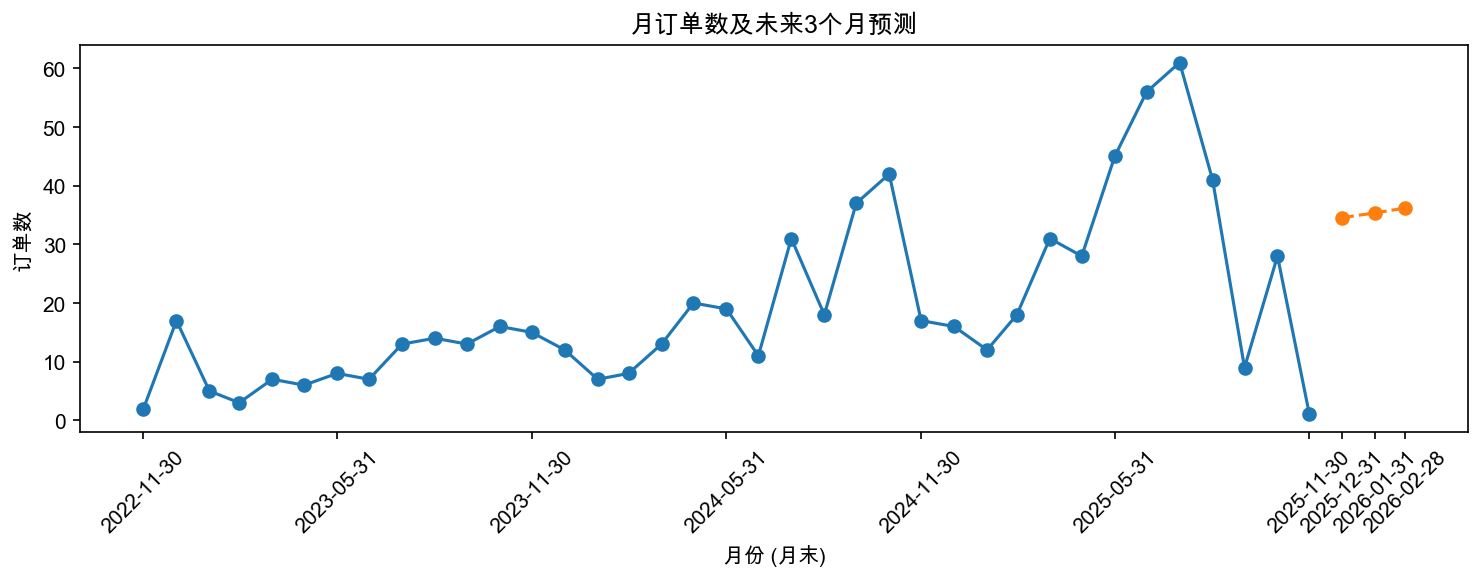


🔍 Judging result...

✅ PASSED - Score: 4/5
Reasoning: Mostly accurate and relevant: the agent produced a clear CLV method, top-customer CLV proxies, monthly history and a 3-month order forecast that align with the reference forecast (~35 orders/month) and historical patterns. However it did not state the reference's single-customer CLV ≈ ¥27,181 or the specific monthly revenue projection (~¥692) — instead reporting different per-customer proxies and a custom expected_years formula. Minor completeness gap on the exact CLV and revenue figures requested, but overall analysis, forecasts, and recommendations are sound.

EVALUATION SUMMARY
Total Questions: 10
Passed: 7 (70.0%)
Failed: 3
Average Score: 3.10/5

Score Distribution:
  0: ██ (2)
  1:  (0)
  2: █ (1)
  3: █ (1)
  4: ████ (4)
  5: ██ (2)

💾 Results saved to: eval_output/eval_results.json


In [70]:
# Run evaluation on all questions
eval_results = run_evaluation(
    df_eval=df_eval,
    df_data=df_eleme,
    output_dir="./eval_output",
    use_reflection=True,
    include_viz=True,
    save_results=True
)